# Neural and Evolutionary Learning - Final Project

## Notebook 2 - Problem Applications

## **2.4.** *NeuroEvolution of Augmenting Topologies* - `NEAT`

|       Student Name      |    Student ID   |
|           ---           |       ---       |
|     Andriani Kakoulli   |     20230484    |
|       Susana Pires      |     20230540    |

### **1. Introduction**

> **CONTEXT** <br>

Data from Automatic Milking Systems (AMSs). <br>

Milk contents (fat, protein, lactose) are emasured at each milking event, to evaluate milk quality. This measurement is through a colourimetric mehtod that requires calibration every 2 weeks. <br>

> **GOAL** <br>

To infer the milk components - *Lactose* - from the other sensor data from the milking robots. <br>
Develop model to **predict** Lactose content.

### **2. Environment preparation**

#### **2.1. Imports**

In [1]:
# %pip install git+https://github.com/CodeReclaimers/neat-python.git

In [2]:
import os
import csv

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statistics as sts
from torch.utils.data import DataLoader, TensorDataset

import torch
from torch.utils.data import TensorDataset, DataLoader

#import neat-python
import neat
import graphviz
from NEAT.visualize import draw_net, plot_stats, plot_species

#### **2.2. Global settings**

In [3]:
seed = 91

# seeds = 6, 8, 11, 12, 21, 27, 29, 33, 66, 91
# Susana - my device will always be cpu because my pc doesn't have a NVIDIA (nor a recent AMD) GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **2.3. Data**

* **Import data**

In [4]:
data = pd.read_csv('dt_cleaned.csv').to_numpy()[:, 1:]
target = pd.read_csv('y_lact_cleaned.csv').to_numpy()
[data.shape, target.shape]

[(177, 13), (177, 1)]

* **Data split** <br>
Since we are working with a very small dataset, the best decision for the split is by K-fold Cross Validation, but first we will use the Hold-Out Method. Then, after everything is running smoothly, we might adapt to Cross Validation.

In [5]:
# Train+Val and Test sets
X_tval, X_test, y_tval, y_test = train_test_split(data, target)

# Train and Val sets (load from X_tval and y_tval)
X_train, X_val, y_train, y_val = train_test_split(X_tval, y_tval)

In [7]:
[X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape]

[(99, 13), (99, 1), (33, 13), (33, 1), (45, 13), (45, 1)]

### **3. NEAT Configuration**

#### **3.1. Defining function `eval_genomes`:** <br>

Get the fitness (in this case RMSE) for each train and validation set.

In [8]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        # Negative RMSE
        genome.fitness = 0.0
        for xi, xo in zip(X_train, y_train):
            output = net.activate(xi)                           # activate is a method of FeedForwardNetwork that throws the input through the network
            genome.fitness += (output[0] - xo)**2
        genome.fitness = -(genome.fitness[0]/y_train.shape[0])**.5

        # Negative RMSE Validation
        genome.fitness_val = 0.0
        for xi, xo in zip(X_val, y_val):
            output = net.activate(xi)
            genome.fitness_val += (output[0] - xo)**2
        genome.fitness_val = -(genome.fitness_val[0]/y_val.shape[0])**.5

        # TEST
        # Negative RMSE Test
        genome.fitness_test = 0.0
        for xi, xo in zip(X_test, y_test):
            output = net.activate(xi)
            genome.fitness_test += (output[0] - xo)**2
        genome.fitness_test = -(genome.fitness_test[0]/y_test.shape[0])**.5

#### **3.2. Set *configuration file*** <br>

Adapted configuration file.

In [9]:
config_file = 'NEAT\config-feedforward-neat'
with open(config_file, 'r') as f:
    print(f.read())

#--- parameters for the NEAT Milk Lactose experiment ---#

[NEAT]
# The function used to compute the termination 
# criterion from the set of genome fitnesses. 
fitness_criterion     = max

# When the fitness computed by fitness_criterion 
# meets or exceeds this threshold, the evolution 
# process will terminate, with a call to any 
# registered reporting class 'found_solution' method.
# Note
# The found_solution method is not called if the maximum 
# number of generations is reached without the above 
# threshold being passed.
fitness_threshold     = 0.

# If no_fitness_termination evaluates to True, 
# then the fitness_criterion and fitness_threshold are ignored 
# for termination; only valid if termination by a maximum number 
# of generations passed to population.Population.run() is enabled, 
# and the found_solution method is called upon 
# generation number termination.
no_fitness_termination = False

# The number of individuals in NEAT population.
pop_size              = 250

#

#### **3.3. Load *configuration file***

In [10]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

### **4. Experiment**

#### **4.1. Create a *population*** <br>

It is the top-level object for a NEAT run, it's based on the loaded configuration *config*.

In [11]:
pp = neat.Population(config)

* Set some ways of checking the progress.

In [12]:
pp.add_reporter(neat.StdOutReporter(False))
statistics = neat.StatisticsReporter()
pp.add_reporter(statistics)
pp.add_reporter(neat.Checkpointer(5))

#### **4.2. Run until finding a solution.** <br>

In [13]:
winner = pp.run(eval_genomes, 50)


 ****** Running generation 0 ****** 

Population's average fitness: -999.09091 stdev: 864.20897
Best fitness: -50.61887 - size: (6, 70) - species 1 - id 19
Average adjusted fitness: 0.864
Mean genetic distance 3.557, standard deviation 0.286
Population of 250 members in 1 species
Total extinctions: 0
Generation time: 3.525 sec

 ****** Running generation 1 ****** 

Population's average fitness: -295.31114 stdev: 457.24555
Best fitness: -2.97723 - size: (6, 55) - species 1 - id 364
Average adjusted fitness: 0.924
Mean genetic distance 3.497, standard deviation 0.290
Population of 250 members in 1 species
Total extinctions: 0
Generation time: 3.118 sec (3.322 average)

 ****** Running generation 2 ****** 

Population's average fitness: -85.32011 stdev: 267.57821
Best fitness: -1.53926 - size: (6, 56) - species 1 - id 646
Average adjusted fitness: 0.960
Mean genetic distance 3.086, standard deviation 0.444
Population of 250 members in 1 species
Total extinctions: 0
Generation time: 2.917

### **5. Results**

#### **5.1. Get a visual interpretation.**

**Dictionary for the features:** <br>
lactation: 'lct' <br>
delivery_age_years: 'dlv_ay' <br>
'dim' <br>
dry_days: 'dd' <br>
forage_kg_day: 'fkd' <br>
rumination_min_day: 'rmd' <br>
milk_kg_day: 'mkd' <br>
milk_kg_min_robot: 'mkmr' <br>
milkings_day: 'md' <br>
errors_by_100_milkings: 'er_100m' <br>
high_cdt_by_100_milkings: 'hcdt_100m' <br>
watery_by_100_milkings: 'w100m' <br>
refusals_by_milking: 'ref_bm' <br>
colostrum_separated_kg: 'cskg' <br>

'lct', 'dlv_ay', 'dim', 'dd', 'fkd', 'rmd', 'mkd', 'mkmr', 'md', 'er_100m', 'hcdt_100m', 'w100m', ref_bm', 'cskg'

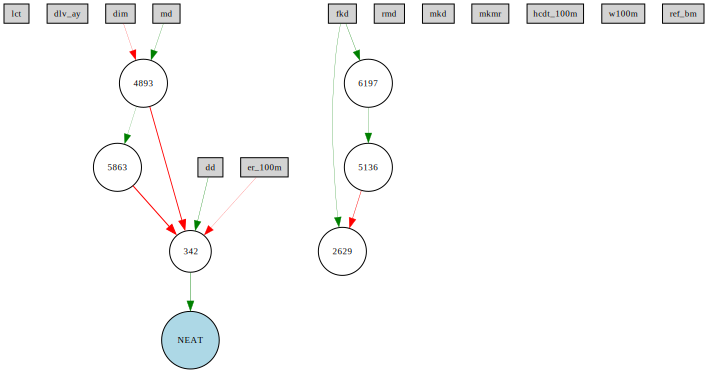

In [14]:
data_fts = ['lct', 'dlv_ay', 'dim', 'dd', 'fkd', 'rmd', 'mkd', 'mkmr', 'md', 'er_100m', 'hcdt_100m', 'w100m', 'ref_bm', 'cskg']
input_names = {0: 'NEAT'}
for i in range(len(data_fts)):
    input_names.update({-1*(i+1): data_fts[i]})

draw_net(config, winner, True, node_names=input_names, prune_unused=True)

#### **5.2. Check *best/winning genome***

In [15]:
print('\nBest genome:\n{!s}'.format(winner))

# Needs to be converted to nn (on Outputs cell)


Best genome:
Key: 10148
Fitness: -0.06399571159637707
Nodes:
	0 DefaultNodeGene(key=0, bias=4.88223828327583, response=1.0, activation=relu, aggregation=mean)
	342 DefaultNodeGene(key=342, bias=1.4931925098480672, response=1.0, activation=gauss, aggregation=sum)
	2629 DefaultNodeGene(key=2629, bias=1.1762333733238584, response=1.0, activation=relu, aggregation=mean)
	3331 DefaultNodeGene(key=3331, bias=0.06331043652925228, response=1.0, activation=identity, aggregation=mean)
	3354 DefaultNodeGene(key=3354, bias=0.17559195579302161, response=1.0, activation=gauss, aggregation=sum)
	4893 DefaultNodeGene(key=4893, bias=-1.4178321445674134, response=1.0, activation=relu, aggregation=sum)
	5003 DefaultNodeGene(key=5003, bias=2.14509318438079, response=1.0, activation=identity, aggregation=mean)
	5136 DefaultNodeGene(key=5136, bias=-0.4298815238811672, response=1.0, activation=relu, aggregation=sum)
	5344 DefaultNodeGene(key=5344, bias=1.7850195963679687, response=1.0, activation=gauss, agg

#### **5.3. Outputs**

In [16]:
# Show output of the most fit genome against training data.
print('\nOutput:')

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

for xi, xo in zip(X_train, y_train):
# for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    #print("  expected output {!r}, got {!r}".format(xo, output))
    
out_train = []
for xi in X_train:
    output = winner_net.activate(xi)
    out_train.append(output[0])

out_val = []
for xi in X_val:
    output = winner_net.activate(xi)
    out_val.append(output[0])

# TEST predictions
out_test = []
for xi in X_test:
    output = winner_net.activate(xi)
    out_test.append(output[0])


Output:


In [17]:
out_test

[4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.882238283275832,
 4.88223828327583,
 4.882334998664991,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.882238283275891,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828344273,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.89190811913396,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583,
 4.88223828327583]

#### **5.4. RMSE**

In [18]:
expected_output = y_test 
got_output = out_test

rmse = np.sqrt(mean_squared_error(expected_output, got_output))
print("RMSE:", rmse)

RMSE: 0.07405593163525723


In [22]:
# Re-run the notebook and changing the seed - to get different RMSE values
# (seed=6, 8, 11, 12, 21, 27, 29, 33, 66, 91)
# list of 10 RMSE-test values
list_RMSE = [0.06421294813838227, 0.052080539691019494, 0.06241040499372979, 0.059267949283075196, 0.05692388766008969,
             0.06820785744466334, 0.06257905782196159, 0.0605951983058181, 0.0745904275107406, 0.07405593163525723]

# compute the median of list_RMSE
median_RMSE = sts.median(list_RMSE)
round(median_RMSE, 6)

0.062495

> **Median RMSE on test set: 0.062495** <br>
>
> Achieved with 50 generations and the parameters on *config-feedforward-neat*.


#### Visualize

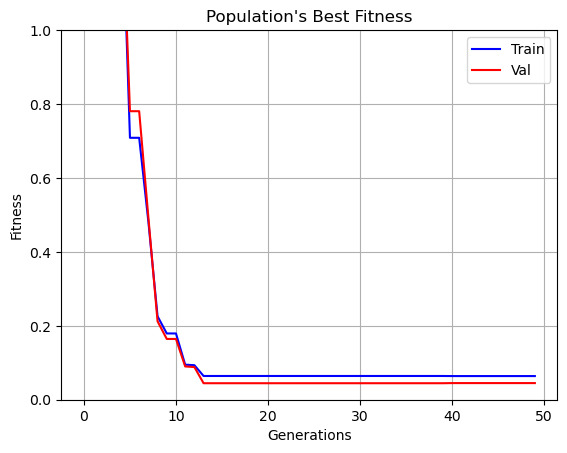

In [23]:
plot_stats(statistics, ylog=False, y_max=1, view=True)

In [24]:
# They are all of the same size when the graph is full of the same color
# plot_species(statistics, view=True)